In [321]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from statistics import mean

In [322]:
from gym.wrappers import Monitor

In [323]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [324]:
import math
import copy
from torch.distributions import Categorical
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [325]:
#Hyper-parameters
solved_reward = 30           # stop training if avg_reward > solved_reward
log_interval = 100           # print avg reward in the interval
max_episodes = 1000          # max training episodes
max_timesteps = 500          # max timesteps in one episode
n_latent_var = 64            # number of variables in hidden layer
update_timestep = 2000       # update policy every n timesteps
lr = 0.002
betas = (0.9, 0.999)
gamma = 0.01                # discount factor
K_epochs = 1                 # update policy for K epochs
eps_clip = 0.2               # clip parameter for PPO
random_seed = None
render = False
epsilon = 0.2                #need to change it to max(advantage)
dkl=1                       #need to change it to KL divergence between old and new policies
Q_r=[]
Q_r1=[]
a=[]
Q=np.zeros((max_timesteps,2))
#print(Q)

In [326]:
class CartPoleAI(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc = nn.Sequential(
                        nn.Linear(4,128, bias=True),
                        nn.ReLU(),
                        nn.Linear(128,2, bias=True),
                        nn.Softmax(dim=1)
                        )

                
        def forward(self, inputs):
            x = self.fc(inputs)
            return x

In [327]:
def init_weights(m):
    
        # nn.Conv2d weights are of shape [16, 1, 3, 3] i.e. # number of filters, 1, stride, stride
        # nn.Conv2d bias is of shape [16] i.e. # number of filters
        
        # nn.Linear weights are of shape [32, 24336] i.e. # number of input features, number of output features
        # nn.Linear bias is of shape [32] i.e. # number of output features
        
        if ((type(m) == nn.Linear) | (type(m) == nn.Conv2d)):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.00)

In [328]:
def behavioural_policy(agents):
    return agent

In [329]:
def KL_divergence(agent1,agent2):
    return KL

In [330]:
def return_random_agents(num_agents):
    
    agents = []
    for _ in range(num_agents):
        
        agent = CartPoleAI()
        
        for param in agent.parameters():
            param.requires_grad = False
            
        init_weights(agent)
        agents.append(agent)
        
        
    return agents

In [331]:
def run_agents(agents):
    
    reward_agents = []
    env = gym.make("CartPole-v0")
    #print("Enter")
    for agent in agents:#There is only one agent in the list. But it is necessary to pass the agents in the form of lists to make it iterable and work on it
        agent.eval()
        #print("HELLLO!!!!!!")
        observation = env.reset()
        r=0
        a.clear()
        Q_r1.clear()
        Q_r.clear()
        for i in range(max_timesteps):
            
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            #print(output_probabilities)
            Q[i][0]=output_probabilities[0]
            Q[i][1]=output_probabilities[1]
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            a.append(action)
            new_observation, reward, done, info = env.step(action)
            r+=reward
            Q_r.append(r)
            observation = new_observation
            if(done):
                break

        reward_agents.append(r)
        #reward_agents.append(s)
        d_r=0
        #print("Non-discounted Reward:::",Q_r)
        for rew in reversed(Q_r):
            if rew==Q_r[len(Q_r)-1]:
                d_r=0
            else:
                d_r=rew+gamma*d_r
            Q_r1.insert(0,d_r)
            
        
    #print("Exit")
    #Q=Q[~np.all(Q==0,axis=1)]
    #print("Reward:::",reward_agents)
    #print("Probabilities:::",Q)
    #print("Actions:::",a)
    #print("Discounted Reward,i.e,Q:::",Q_r1)
    
    
    return reward_agents

In [332]:
def run_target_agents(agents):
    
    reward_agents = []
    env = gym.make("CartPole-v0")
    #print("Enter")
    for agent in agents:#There is only one agent in the list. But it is necessary to pass the agents in the form of lists to make it iterable and work on it
        agent.eval()
        #print("HELLLO!!!!!!")
        observation = env.reset()
        r=0
        s=0
        i=0
        #print("SIZE OF ACTIONS:",len(a),"SIZE OF PROBABILITIES:",Q.shape,"SIZE OF DISCOUNTED REWARDS:",len(Q_r1))
        for i in range(len(Q_r1)-1):
            
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            L_pi=(output_probabilities[a[i]]/Q[i][a[i]])*Q_r1[i]
            #print("L_pi",L_pi)
            #surr1= L_pi-(4*max(Q_r1)*gamma*dkl/np.square(1-gamma))
            
            #print(output_probabilities)
            s+=L_pi
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            new_observation, reward, done, info = env.step(action)
            #r+=(gamma**i)*reward
            
            #s=s+1
            observation = new_observation

            if(done):
                break
        #print("S:",s)
        #print("Max Q_r1:",max(Q_r1))
        surr1= s-(4*max(Q_r1)*gamma*dkl/np.square(1-gamma))
        #print("Surr1:",surr1)
        reward_agents.append(surr1)        
        #reward_agents.append(s)
    #print("Exit")
    #print("REWARD AGENTS",reward_agents)
    #print(reward_agents)
    return reward_agents

In [333]:
def alternate_average_score(agent, runs):
    score = 0.
    for i in range(runs):
        score += run_target_agents([agent])[0]
    return score/runs

In [334]:
def return_average_score(agent, runs):
    score = 0.
    for i in range(runs):
        score += run_agents([agent])[0]
    return score/runs

In [335]:
def run_agents_n_times(agents, runs):
    avg_score = []
    for agent in agents:
        if agent==agents[0]:
            avg_score.append(return_average_score(agent,runs))
        else:
            avg_score.append(alternate_average_score(agent,runs))
    return avg_score

In [336]:
def mutate(agent):

    child_agent = copy.deepcopy(agent)
    
    mutation_power = 0.02 #hyper-parameter, set from https://arxiv.org/pdf/1712.06567.pdf
            
    for param in child_agent.parameters():
    
        if(len(param.shape)==4): #weights of Conv2D

            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    for i2 in range(param.shape[2]):
                        for i3 in range(param.shape[3]):
                            
                            param[i0][i1][i2][i3]+= mutation_power * np.random.randn()
                                
                                    

        elif(len(param.shape)==2): #weights of linear layer
            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    
                    param[i0][i1]+= mutation_power * np.random.randn()
                        

        elif(len(param.shape)==1): #biases of linear layer or conv layer
            for i0 in range(param.shape[0]):
                
                param[i0]+=mutation_power * np.random.randn()

    return child_agent

In [337]:
def return_children(agents, sorted_parent_indexes, elite_index):
    
    children_agents = []
    
    #first take selected parents from sorted_parent_indexes and generate N-1 children
    for i in range(len(agents)-1):
        
        selected_agent_index = sorted_parent_indexes[np.random.randint(len(sorted_parent_indexes))]
        children_agents.append(mutate(agents[selected_agent_index]))

    #now add one elite
    elite_child = add_elite(agents, sorted_parent_indexes, elite_index)
    children_agents.append(elite_child)
    elite_index=len(children_agents)-1 #it is the last one
    
    return children_agents, elite_index

In [338]:
def add_elite(agents, sorted_parent_indexes, elite_index=None, only_consider_top_n=10):
    
    candidate_elite_index = sorted_parent_indexes[:only_consider_top_n]
    
    if(elite_index is not None):
        candidate_elite_index = np.append(candidate_elite_index,[elite_index])
        
    top_score = None
    top_elite_index = None
    
    for i in candidate_elite_index:
        score = return_average_score(agents[i],runs=5)
        print("Score for elite i ", i, " is ", score)
        
        if(top_score is None):
            top_score = score
            top_elite_index = i
        elif(score > top_score):
            top_score = score
            top_elite_index = i
            
    print("Elite selected with index ",top_elite_index, " and score", top_score)
    
    child_agent = copy.deepcopy(agents[top_elite_index])
    return child_agent

In [339]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)



Generation  0  | Mean rewards:  82.28374991831946  | Mean of top 5:  99.69888316684936
Top  20  scores [216 324  21 101 301 408 155 490 306 406 304 120 393 434 225 302 116 350
 197 356]
Rewards for top:  [101.43137964837403, 99.94059720557784, 99.84394170212833, 99.53385293491868, 97.7446443432479, 97.45912336269632, 97.39289394130985, 97.33218148891585, 96.96846909608615, 96.61152753954454, 96.48037330329957, 95.88358233438404, 95.71895861065269, 95.71251745321185, 95.71036415081822, 95.70486205043747, 95.605480492979, 95.35159332450388, 95.20192347160683, 95.13113960478935]
Score for elite i  216  is  16.6
Score for elite i  324  is  18.6
Score for elite i  21  is  29.2
Score for elite i  101  is  20.6
Score for elite i  301  is  22.4
Score for elite i  408  is  18.6
Score for elite i  155  is  33.8
Score for elite i  490  is  16.8
Score for elite i  306  is  23.2
Score for elite i  406  is  19.0
Elite selected with index  155  and score 33.8


Generation  1  | Mean rewards:  100.4

Score for elite i  121  is  13.2
Score for elite i  351  is  13.0
Score for elite i  353  is  11.8
Score for elite i  475  is  12.8
Score for elite i  231  is  12.8
Score for elite i  205  is  14.6
Score for elite i  206  is  26.6
Score for elite i  239  is  14.4
Score for elite i  257  is  13.2
Score for elite i  435  is  13.8
Score for elite i  499  is  42.0
Elite selected with index  499  and score 42.0


Generation  9  | Mean rewards:  29.837271298341737  | Mean of top 5:  36.39177969355278
Top  20  scores [ 74 134 475 367 161  77 464 422 335 390  39 160  69 125 146 192 480 389
 255 421]
Rewards for top:  [36.70999939765572, 36.531634158821014, 36.37711223601418, 36.340814133592126, 35.999338541680885, 35.98127552443534, 35.92367195239883, 35.8218162057452, 35.65843895345362, 35.586514621024335, 35.525631975901625, 35.52104994042806, 35.50168725266467, 35.35135049228184, 35.266877039146955, 35.21076225661405, 35.19420474420551, 35.14557291547799, 35.14508102450381, 35.1113916268295

Score for elite i  499  is  20.4
Elite selected with index  2  and score 25.0


Generation  17  | Mean rewards:  95.4202481479994  | Mean of top 5:  132.45987606205543
Top  20  scores [ 90 344  23 118 179 451 382 489 105  69 410 247 370 354 309 381 315   4
  12  86]
Rewards for top:  [134.80472872613788, 132.363243169741, 131.73565150367546, 131.72526586618048, 131.67049104454233, 130.69985088190109, 128.72014585684173, 127.8997794433188, 127.33158487831497, 127.19654630659728, 127.14068971617624, 125.37801133947043, 125.11870231645125, 124.28374730893887, 124.11345828716655, 123.9980339693646, 123.50772320644707, 123.40200227141871, 123.24160323032822, 123.23879238035609]
Score for elite i  90  is  12.6
Score for elite i  344  is  19.2
Score for elite i  23  is  27.2
Score for elite i  118  is  37.4
Score for elite i  179  is  23.4
Score for elite i  451  is  28.6
Score for elite i  382  is  22.8
Score for elite i  489  is  20.8
Score for elite i  105  is  38.0
Score for elite i  69  

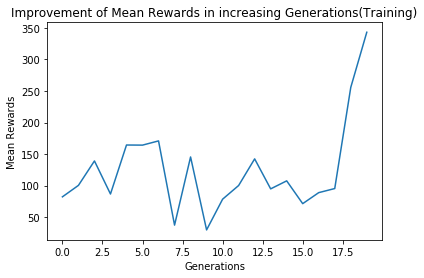

In [340]:
game_actions = 2 #2 actions possible: left or right

#disable gradients as we will not use them
torch.set_grad_enabled(False)

# initialize N number of agents
num_agents = 500
agents = return_random_agents(num_agents)

# How many top agents to consider as parents
top_limit = 20

# run evolution until X generations
generations = 20

elite_index = None
n=[]

for generation in range(generations):

    # return rewards of agents
    rewards = run_agents_n_times(agents, 1) #return average of 3 runs later
    #print(rewards)
    #sort by rewards
    sorted_parent_indexes = np.argsort(rewards)[::-1][:top_limit] #reverses and gives top values (argsort sorts by ascending by default) https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
    print("")
    print("")
    top_rewards = []
    
    for best_parent in sorted_parent_indexes:
        top_rewards.append(rewards[best_parent])
    
    print("Generation ", generation, " | Mean rewards: ", np.mean(rewards), " | Mean of top 5: ",np.mean(top_rewards[:5]))
    #print(rewards)
    print("Top ",top_limit," scores", sorted_parent_indexes)
    print("Rewards for top: ",top_rewards)
    
    
    n.append(np.mean(rewards))
    # setup an empty list for containing children agents
    children_agents, elite_index = return_children(agents, sorted_parent_indexes, elite_index)

    # kill all agents, and replace them with their children
    agents = children_agents
x=np.arange(generations)
plt.plot(x,n)
plt.title('Improvement of Mean Rewards in increasing Generations(Training)')
plt.ylabel('Mean Rewards')
plt.xlabel('Generations')
plt.show()

In [341]:
def play_agent(agent):
        env = gym.make("CartPole-v0")
        
        env_record = Monitor(env, './video', force=True)
        observation = env_record.reset()
        last_observation = observation
        r=0
        j=[]
        episode_durations=[]
        timestep=0
        for timestep in range(250):
            env_record.render()
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            new_observation, reward, done, info = env_record.step(action)
            r=r+reward
            j.append(r)
            observation = new_observation

            if(done):
                break

        env_record.close()

        print("Rewards: ",r)

In [342]:
play_agent(agents[0])

Rewards:  13.0
